## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

### 1. 試比較 save_best_only 與否的差異 : 一般都會用save_best_only=True 存最佳模型 !

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型

參數說明：
filepath: 儲存模型的路徑與檔名
mointor: 以什麼指標作為判斷標準

save_best_only: 是否只要儲存最好的   預設False
if save_best_only=True, it only saves when the model is considered the "best"

save_weights_only: 預設False
if True, then only the model's weights will be saved (model.save_weights(filepath)), 
else the full model is saved (model.save(filepath)).

"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp_D086_HW.h5", 
                             monitor="val_loss",
                             verbose=1,
                             save_best_only=False)

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("./tmp_D086_HW.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
print(f"loss_best={loss_loadback} , accuracy_best={acc_loadback} ")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

49/49 [==============================] - 1s 26ms/step - loss: 0.9751 - accuracy: 0.6710 - val_loss: 1.4476 - val_accuracy: 0.4964
Epoch 26/50
48/49 [============================>.] - ETA: 0s - loss: 0.9522 - accuracy: 0.6807
Epoch 26: saving model to .\tmp_D086_HW.h5
49/49 [==============================] - 1s 25ms/step - loss: 0.9522 - accuracy: 0.6808 - val_loss: 1.4407 - val_accuracy: 0.4963
Epoch 27/50
48/49 [============================>.] - ETA: 0s - loss: 0.9325 - accuracy: 0.6880
Epoch 27: saving model to .\tmp_D086_HW.h5
49/49 [==============================] - 1s 25ms/step - loss: 0.9341 - accuracy: 0.6873 - val_loss: 1.4477 - val_accuracy: 0.5008
Epoch 28/50
49/49 [==============================] - ETA: 0s - loss: 0.9151 - accuracy: 0.6933
Epoch 28: saving model to .\tmp_D086_HW.h5
49/49 [==============================] - 1s 24ms/step - loss: 0.9151 - accuracy: 0.6933 - val_loss: 1.4691 - val_accuracy: 0.4933
Epoch 29/50
48/49 [============================>.] - ETA: 0s - los

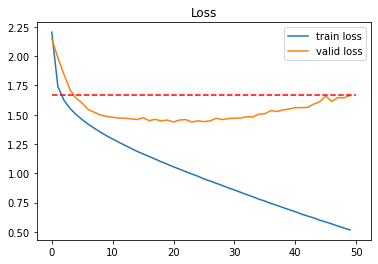

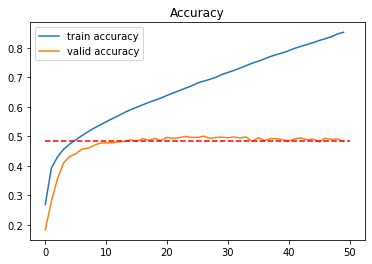

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

### ANS: save_best_only=False 不是只存最佳模型, 而是每筆model都存, 會覆蓋前一筆, 所以最後存下的會是epoch最後一次的模型. 

### 2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [11]:
from keras.callbacks import ModelCheckpoint

model_ckpt_w = ModelCheckpoint(filepath="./tmp_D086_HW2.h5", 
                             monitor="val_loss",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True)

In [12]:
keras.backend.clear_session() # 把舊的 Graph 清掉

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt_w]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

49/49 [==============================] - 1s 25ms/step - loss: 1.0266 - accuracy: 0.6521 - val_loss: 1.4641 - val_accuracy: 0.4858
Epoch 23/50
49/49 [==============================] - ETA: 0s - loss: 1.0039 - accuracy: 0.6596
Epoch 23: val_loss did not improve from 1.45170
49/49 [==============================] - 1s 24ms/step - loss: 1.0039 - accuracy: 0.6596 - val_loss: 1.4682 - val_accuracy: 0.4903
Epoch 24/50
49/49 [==============================] - ETA: 0s - loss: 0.9839 - accuracy: 0.6670
Epoch 24: val_loss did not improve from 1.45170
49/49 [==============================] - 1s 24ms/step - loss: 0.9839 - accuracy: 0.6670 - val_loss: 1.4671 - val_accuracy: 0.4890
Epoch 25/50
48/49 [============================>.] - ETA: 0s - loss: 0.9624 - accuracy: 0.6757
Epoch 25: val_loss did not improve from 1.45170
49/49 [==============================] - 1s 23ms/step - loss: 0.9633 - accuracy: 0.6752 - val_loss: 1.4593 - val_accuracy: 0.4944
Epoch 26/50
48/49 [============================>.] 

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x00000213093B6400>.

In [26]:
# 將模型與權重重新建回並預測 x_test !!
keras.backend.clear_session() # 把舊的 Graph 清掉

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

# Load back (weights)
model.load_weights("./tmp_D086_HW2.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
print(f"loss_best={loss_loadback} , accuracy_best={acc_loadback} ")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

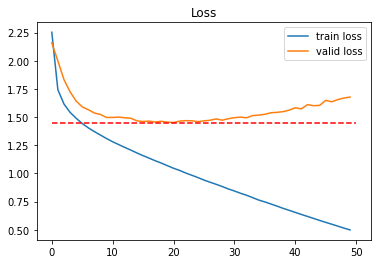

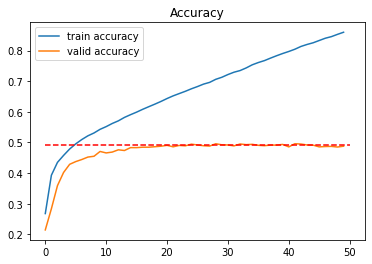

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()